### Imports 

In [11]:
import numpy as np
import pandas as pd
import json
from ase import Atoms
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV,ElasticNet,ElasticNetCV, BayesianRidge, LassoLars,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVR 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from ase.geometry import get_distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

from sklearn.utils import check_array

## Loading data and setting up the data frames

In [2]:
data_dir = "" # Specify your data path (Folder in which the files are placed)

In [59]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))
print(train.shape)
train.head(n = 5)

(10886, 6)


,formula,energy,mass,E_gap,KS_gap,atoms
7465,TiC63F10H38N4O3,-778.280065,1136.873032,3.964256,1.534403,"(Atom('C', [11.9822242501, 25.3989654616, 9.72..."
10902,TiC75F8H43N7O6S,-935.355899,1370.126225,3.142127,0.752820,"(Atom('C', [15.5658780205, 20.0878222144, 9.54..."
3467,ZnC83F8H53N7O2,-1006.671405,1397.751225,2.900543,0.848549,"(Atom('C', [12.1166765284, 25.7664850742, 10.1..."
2420,ZnC73F8H60N4O4,-935.786791,1274.674225,4.060018,1.636423,"(Atom('C', [11.9754118551, 23.8575643497, 9.59..."
11955,TiC65F8H37N5O7S2,-822.675958,1264.013225,3.323376,0.941463,"(Atom('C', [15.3824310276, 20.5716972912, 9.00..."


# Setting up a simple linear model to fit the Porpyrin energies

## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [6]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in train.atoms:
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)
print('Max {} atoms'.format(max_number_of_atoms))

Max 210 atoms


#### Coulomb matrix

In [12]:
def coulomb_matrix(atoms):
    N = len(atoms)
    cmat = np.zeros((N, N))
    
    atomic_numbers = atoms.get_atomic_numbers()
    positions = atoms.get_positions()
    distances = squareform(pdist(positions)) # Unique distances
    for i in range(N):
        for j in range(N):
            if i == j:
                cmat[i, j] = 0.5*atomic_numbers[i]**2 
            else:
                cmat[i, j] = atomic_numbers[i]*atomic_numbers[j]/distances[i, j]
    
    # Sorting according to l1 norm of columns
    sortidxs = np.einsum('ij,ij->ij', cmat, cmat).argsort()
    cmat = cmat[np.arange(cmat.shape[0])[:,None], sortidxs]
    return cmat

In [13]:
def coulomb_matrix_padding(atoms, n_atoms_max):
    N = len(atoms)
    
    if N <= n_atoms_max:
        cmat = np.zeros((n_atoms_max, n_atoms_max))

        atomic_numbers = atoms.get_atomic_numbers()
        positions = atoms.get_positions()
        distances = squareform(pdist(positions)) # Unique distances
        for i in range(N):
            for j in range(N):
                if i == j:
                    cmat[i, j] = 0.5*atomic_numbers[i]**2 
                else:
                    cmat[i, j] = atomic_numbers[i]*atomic_numbers[j]/distances[i, j]
    else:
        N = n_atoms_max
        cmat = np.zeros((N, N))
        atomic_numbers = atoms.get_atomic_numbers()
        positions = atoms.get_positions()
        distances = squareform(pdist(positions)) # Unique distances
        for i in range(N):
            for j in range(N):
                if i == j:
                    cmat[i, j] = 0.5*atomic_numbers[i]**2 
                else:
                    cmat[i, j] = atomic_numbers[i]*atomic_numbers[j]/distances[i, j]
    
    # Sorting according to l1 norm of columns
    sortidxs = np.einsum('ij,ij->ij', cmat, cmat).argsort()
    cmat = cmat[np.arange(cmat.shape[0])[:,None], sortidxs]
    
    return cmat

In [19]:
cmat = coulomb_matrix_padding(train.atoms[0],max_number_of_atoms)
cmat

array([[ 0.        ,  0.        ,  0.        , ..., 24.81785047,
        26.15660134, 30.08941452],
       [ 0.        ,  0.        ,  0.        , ..., 25.45233554,
        30.18936826, 41.6995647 ],
       [ 0.        ,  0.        ,  0.        , ..., 25.45233554,
        25.45268356, 37.10755203],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [26]:
cmats = np.zeros((len(train),max_number_of_atoms**2))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix_padding(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(cmats)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Setting target and feature vector

In [49]:
X = pd.DataFrame(data=cmats,index=train.index)
y = train.energy

In [50]:
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (10886, 44100)
y: (10886,)


## Splitting into test and train set

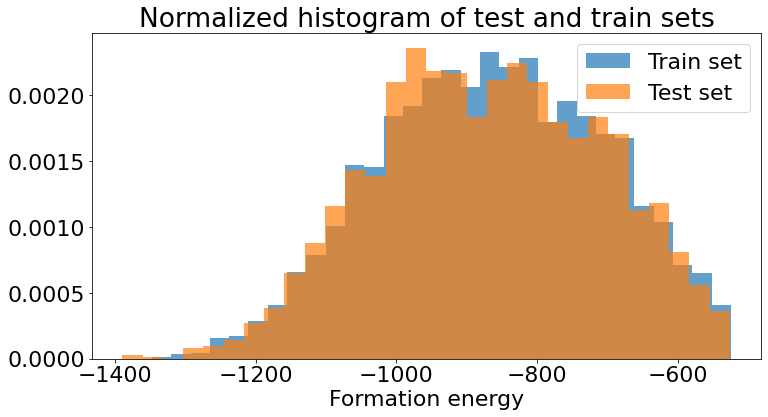

In [51]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=250)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Formation energy")
plt.legend()
plt.show()


## Dimensionality reduction

In [52]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [53]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

n_comp_PCA = 10

pca = PCA(n_components = n_comp_PCA).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
print("With {} PCA components {var:0.4f}% of the variance is explained".format(n_comp_PCA, var = 100*np.sum(pca.explained_variance_ratio_)))
print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

With 10 PCA components 57.1019% of the variance is explained
X_train: (8708, 10)
X_test: (2178, 10)


# Sklearn models 

In [54]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [55]:
model = LinearRegression()

In [56]:
model.fit(X_train, y_train)

LinearRegression()

In [57]:
from sklearn.metrics import r2_score
r2 = r2_score(model.predict(X_test), y_test)
r2_train = r2_score(model.predict(X_train), y_train)

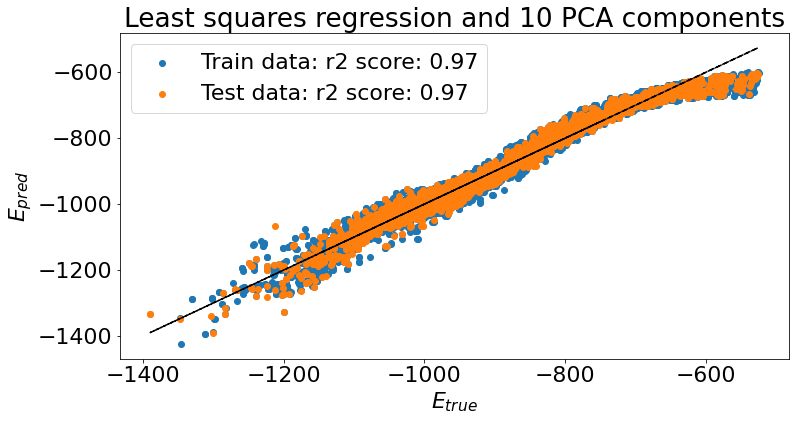

In [58]:
fig = plt.figure(figsize = (12, 6))

plt.title("Least squares regression and 10 PCA components")
plt.scatter(y_train, model.predict(X_train), label = "Train data: r2 score: {r:0.2f}".format(r = r2_train))
plt.scatter(y_test, model.predict(X_test), label = "Test data: r2 score: {r:0.2f}".format(r = r2))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()